In [115]:
#ByRDiE Binary

import numpy as np
import random
from pre_proc import dis_data
from MNIST_read import mnist_read
import pickle
import time
import matplotlib.pyplot as plt

class ByRDiE_parameters:
    def __init__(self, dataset, nodes, epoch, con_rate, rho = 1, screen=False,
                 b=0, train_size=0):
        self.dataset = dataset
        self.nodes = nodes
        self.ep = epoch
        self.con_rate = con_rate 
        self.screen = screen
        self.b = b
        self.train_size = train_size
        self.rho = rho
    pass

def gen_graph(nodes, con_rate, b=0):          # connecting rate between 1-100
    
    re = 1                      # regenerate if graph assumption not satisfied
    while re:
        graph = []
        for _ in range(nodes):
            graph.append([])
        for row in range(nodes):
            graph[row].append(1)
            for col in range(row + 1, nodes):
                d = random.randint(1, 100)
                if d < con_rate:
                    graph[row].append(1)     #form symmetric matrix row by row
                    graph[col].append(1)
                else:
                    graph[row].append(0)
                    graph[col].append(0)
        d_max = 0
        for row in graph:
            if sum(row) > d_max:
                d_max = sum(row)
        w = [row[:] for row in graph]
        for ind, row in enumerate(w):
            d = sum(row)
            w[ind] = [col/d_max for col in row]
            w[ind][ind] = 1 - (d - 1) / d_max
        if all([sum(row) >= 2 * b + 1 for row in graph]):
            re = 0
    return w, graph

def data_prep(dataset, nodes, size=0, load=False):
    if dataset == 'MNIST':
        train_data, train_label, test_data, test_label = mnist_read()
    else:
        raise NameError("Cannot find %s dataset") % (dataset)
    
    if size:
        train_data = train_data[:size]
        train_label = train_label[:size]
        
    full_data = dis_data(train_data, train_label, nodes, shuffle = True)

    
    return full_data, test_data, test_label

def get_neighbor(G):
    neighbor_list = []
    for node in G:
        neighbor = []
        for ind, n in enumerate(node):
            if n == 1:
                neighbor.append(ind)
        neighbor_list.append(neighbor)
    return neighbor_list

def local_update(w, p, data, label, rho=1):        #One step of gradient descent
    # the gradient of squared hinge loss
    _w = np.array(w)
    data = np.array(data)
    grad = np.matmul(data, _w.T)
    grad = np.matmul(np.diagflat(label), grad)
    grad = np.ones(grad.shape) - grad
    grad = np.stack((grad, np.zeros(grad.shape)))
    grad = np.amax(grad, axis = 0)
    grad = np.matmul(grad, np.diagflat(label)) * (-1)    
    grad = np.matmul(grad, data)
    grad = grad / len(label)
    grad = grad + _w / 10
    _w[p] = _w[p] - rho * grad[p]
    return _w

def BRIDGE_update(w, data, label, rho=1):        #One step of gradient descent
    # the gradient of squared hinge loss
    _w = np.array(w)
    data = np.array(data)
    grad = np.matmul(data, _w.T)
    grad = np.matmul(np.diagflat(label), grad)
    grad = np.ones(grad.shape) - grad
    grad = np.stack((grad, np.zeros(grad.shape)))
    grad = np.amax(grad, axis = 0)
    grad = np.matmul(grad, np.diagflat(label)) * (-1)    
    grad = np.matmul(grad, data)
    grad = grad / len(label)
    grad = grad + _w / 10
    _w = _w - rho * grad
    return _w

def label_process(label, _class):
    ova_label = []
    for _set in label:
        new_label = [1 if l == _class else -1 for l in _set]
        ova_label.append(new_label)
    
    return ova_label

def communication(W, p, neighbor, b=0, screen=False):
    ave = []
    out = W[:]
    for node in range(len(W)):
        neighborhood = []
        for n in neighbor[node]:
            neighborhood.append(W[n][p])
        if screen and b:
            neighborhood = np.sort(neighborhood, axis = 0)
            neighborhood = neighborhood[b : -b]
        neighborhood = np.mean(neighborhood, axis = 0)
#        print(neighborhood.shape)
        ave.append(neighborhood)
    for node in range(len(W)):
        out[node][p] = ave[node]
    return out

def BRIDGE_communication(W, neighbor, b=0, screen=False):
    ave = []
    for node in range(len(W)):
        neighborhood = []
        for n in neighbor[node]:
            neighborhood.append(W[n])
        if screen and b:
            neighborhood = np.sort(neighborhood, axis = 0)
            neighborhood = neighborhood[b : -b]
        neighborhood = np.mean(neighborhood, axis = 0)
#        print(neighborhood.shape)
        ave.append(neighborhood)
    return ave

def Byzantine(target, strategy='random'):
    if strategy == 'random':
        fal = np.random.rand(len(target)) * 10 + 5
    return fal

def test(W, data, label):
    acc = []
    for node in W:
        node = np.array(node)
        result = np.matmul(data, node.T)
        l = np.sign(result)
        compare = [1 if i == j else 0 for i, j in zip(l, label)]
        rate = sum(compare) / len(label)
#         print(' accuracy %s'%rate)
        acc.append(rate)
    return acc





In [5]:
#Keep only 5 and 8, 5 labels -1, 8 labels 1
def data_58():
    train_data, train_label, test_data, test_label = mnist_read()
    set_trn_8 = []
    set_tst_8 = []
    set_trn_5 = []
    set_tst_5 = []
    for ind, label in enumerate(train_label):
        if label == 5:
            set_trn_5.append(train_data[ind])
        elif label == 8:
            set_trn_8.append(train_data[ind])
    for ind, label in enumerate(test_label):
        if label == 5:
            set_tst_5.append(test_data[ind])
        elif label == 8:
            set_tst_8.append(test_data[ind])
    return set_trn_5, set_tst_5, set_trn_8, set_tst_8

In [2]:
#Keep only 0 and 1, 0 labels -1, 1 labels 1
def data_01():
    train_data, train_label, test_data, test_label = mnist_read()
    set_trn_0 = []
    set_tst_0 = []
    set_trn_1 = []
    set_tst_1 = []
    for ind, label in enumerate(train_label):
        if label == 0:
            set_trn_0.append(train_data[ind])
        elif label == 1:
            set_trn_1.append(train_data[ind])
    for ind, label in enumerate(test_label):
        if label == 0:
            set_tst_0.append(test_data[ind])
        elif label == 1:
            set_tst_1.append(test_data[ind])
    random.shuffle(set_trn_0)
    random.shuffle(set_trn_1)
    return set_trn_0, set_tst_0, set_trn_1, set_tst_1

In [6]:
a,b,c,d = data_58()

In [7]:
print(len(a))
print(len(b))
print(len(c))
print(len(d))

5421
892
5851
974


In [97]:
def ByRDiE(W, training_data, training_label, neighbors, T=1, stepsize=0.001, N=100, M=1, b=0, iteration=1):
    global_W = W[:]
    save = []
    for t in range(iteration): #average step plus screen 
        for p in range(784):  
            for node in range(b):
                global_W[node] = Byzantine(global_W[node])
            for _ in range(T):
                 
                for node in range(b,M): #gradient descent step
                    global_W[node] = local_update(global_W[node], p, training_data[node], training_label, rho = stepsize)
                global_W = communication(global_W, p, neighbors, b=b, screen=True) 
            if p % 100 == 1:
                save.append(global_W)
        print(t)
    return save
def BRIDGE(W, training_data, training_label, neighbors, stepsize=0.001, N=100, M=1, b=0, iteration=1):
    global_W = W[:]
    save = []
    for t in range(iteration): #average step plus screen  
        for node in range(b):
            global_W[node] = Byzantine(global_W[node])
          
        for node in range(b,M): #gradient descent step
            global_W[node] = BRIDGE_update(global_W[node], training_data[node], training_label, rho = stepsize)
#         print(t)
        global_W = BRIDGE_communication(global_W, neighbors, b=b, screen=True)
        save.append(global_W)
    return save
def DGD(W, training_data, training_label, neighbors, stepsize=0.001, N=100, M=1, b=0, iteration=1):
    global_W = W[:]
    save = []
    for t in range(iteration): #average step plus screen  
        for node in range(b):
            global_W[node] = Byzantine(global_W[node])          
        for node in range(b,M): #gradient descent step
            global_W[node] = BRIDGE_update(global_W[node], training_data[node], training_label, rho = stepsize)
        global_W = BRIDGE_communication(global_W, neighbors, b=b, screen=False)
#         print(t)
        save.append(global_W)
    return save

In [129]:
start = time.time()
#Parameters
M = 50
N = 50
rho = 1.8e-7
b = 5
T = 1
iteration = 60
for r in range(20):
    #Generate graph
    W_0, graph = gen_graph(M, con_rate=50, b=b)
    neighbors = get_neighbor(graph) 
    #Training set distribution / test data
    #5421 0, 5851 1
    training_data = []
    set_trn_0, set_tst_0, set_trn_1, set_tst_1 = data_01()
    test_data = np.concatenate((set_tst_1, set_tst_0))
    test_label = np.concatenate( (np.ones(len(set_tst_1)), (-1) * np.ones(len(set_tst_0))))
    for node in range(M):
        training_data.append(set_trn_1[(node * N) : (node * N + N)] + set_trn_0[(node * N) : (node * N + N)])
    training_label = [1] * N + [-1] * N #1 labels 1, 0 labels -1
    #Initialization
    W_ini = [np.random.rand(784) for _ in range(M)]
#     #ByRDiE
    W_byrdie = ByRDiE(W_ini, training_data, training_label, neighbors, T, rho, N, M, b, iteration)
    #Save consensus / accuracy
    with open('./result/BVB_byrdie_2%d.pickle'%r, 'wb') as handle:
        pickle.dump(W_byrdie, handle)
    #BRIDGE
    W_bridge = BRIDGE(W_ini, training_data, training_label, neighbors, rho, N, M, b, iteration)
    #Save consensus / accuracy
    with open('./result/BVB_bridge_2%d.pickle'%r, 'wb') as handle:
        pickle.dump(W_bridge, handle)       
#     #DGD
    W_dgd = DGD(W_ini, training_data, training_label, neighbors, rho, N, M, b, iteration)
    #Save consensus / accuracy
    with open('./result/BVB_dgd_1%d.pickle'%r, 'wb') as handle:
        pickle.dump(W_dgd, handle)   
    print(time.time() - start)
    start = time.time()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
14384.297688007355


In [143]:
bridge = []
acc_bridge = []
for r in range(4):
    with open('./result/BVB_bridge_3%d.pickle'%r, 'rb') as handle:
        bridge.append(pickle.load(handle))
for r in range(4):
    one_round = []
    for w in bridge[r]:
        acc = test(w, test_data, test_label) # 50
        one_round.append(acc) # 30
    acc_bridge.append(one_round) 
with open('./result/BVB_bridge_accuracy.pickle', 'wb') as handle:
    pickle.dump(acc_bridge, handle)
# acc_bridge = np.mean(acc_bridge, axis = 0)
print(acc_bridge[0][-1])
print(acc_bridge[1][-1])
print(len(acc_bridge)) # 30
print(len(acc_bridge[0])) # 50

dgd = []
acc_dgd = []
for r in range(4):
    with open('./result/BVB_dgd_3%d.pickle'%r, 'rb') as handle:
        dgd.append(pickle.load(handle))
for r in range(4):
    one_round = []
    for w in dgd[r]:
        acc = test(w, test_data, test_label) # 50
        one_round.append(acc) # 30
    acc_dgd.append(one_round) 
with open('./result/BVB_dgd_accuracy.pickle', 'wb') as handle:
    pickle.dump(acc_dgd, handle)
acc_dgd = np.mean(acc_dgd, axis = 0)
print(len(acc_dgd)) # 30
print(len(acc_dgd[0])) # 50

byrdie = []
acc_byrdie = []
for r in range(4):
    with open('./result/BVB_byrdie_3%d.pickle'%r, 'rb') as handle:
        byrdie.append(pickle.load(handle))
for r in range(4):
    one_round = []
    for w in byrdie[r]:
        acc = test(w, test_data, test_label) # 50
        one_round.append(acc) # 30
    acc_byrdie.append(one_round) 
with open('./result/BVB_byrdie_accuracy.pickle', 'wb') as handle:
    pickle.dump(acc_byrdie, handle)
acc_byrdie = np.mean(acc_byrdie, axis = 0)
print(len(acc_byrdie)) # 240
print(len(acc_byrdie[0])) # 50


from matplotlib import pyplot as plt
bridge_b4 = []
byrdie_b4 = []
dgd_b4 = []
axis_byrdie = []
for r in range(60):
    for n in range(780):
        if n % 100 == 1:
            axis_byrdie.append(r * 784 + n)
axis_dgd = [784 * n for n in range(1, 61)]
axis_bridge = [784 * n for n in range(1, 61)]
for t in range(len(acc_byrdie)):
    ave_acc = np.mean(acc_byrdie[t][4:])
    byrdie_b4.append(ave_acc)
for t in range(len(acc_bridge)):
    ave_acc = np.mean(acc_bridge[t][4:])
    bridge_b4.append(ave_acc)
for t in range(len(acc_dgd)):
    ave_acc = np.mean(acc_dgd[t][4:])
    dgd_b4.append(ave_acc)

plt.plot(axis_byrdie[:-7], byrdie_b4[:-7])
plt.plot(axis_bridge[:-1], bridge_b4[:-1])
plt.plot(axis_dgd[:-1], dgd_b4[:-1])
plt.show()
print(byrdie_b4[-1])
print(bridge_b4[-1])

480

ValueError: x and y must have same first dimension, but have shapes (59,) and (3,)

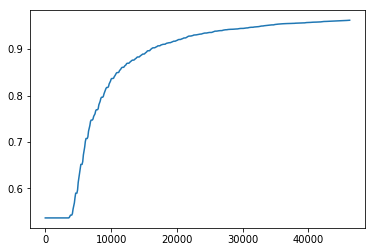

In [145]:
from matplotlib import pyplot as plt
bridge_b4 = []
byrdie_b4 = []
dgd_b4 = []
axis_byrdie = []
for r in range(60):
    for n in range(780):
        if n % 100 == 1:
            axis_byrdie.append(r * 784 + n)
axis_dgd = [784 * n for n in range(1, 61)]
axis_bridge = [784 * n for n in range(1, 61)]
for t in range(len(acc_byrdie)):
    ave_acc = np.mean(acc_byrdie[t][4:])
    byrdie_b4.append(ave_acc)
for t in range(len(acc_bridge)):
    ave_acc = np.mean(acc_bridge[t][4:])
    bridge_b4.append(ave_acc)
for t in range(len(acc_dgd)):
    ave_acc = np.mean(acc_dgd[t][4:])
    dgd_b4.append(ave_acc)

plt.plot(axis_byrdie[:-7], byrdie_b4[:-7])
plt.plot(axis_bridge[:-1], bridge_b4[:-1])
plt.plot(axis_dgd[:-1], dgd_b4[:-1])
plt.show()
print(byrdie_b4[-1])
print(bridge_b4[-1])

In [144]:
bridge = []
acc_bridge = []
for r in range(4):
    with open('./result/BVB_bridge_3%d.pickle'%r, 'rb') as handle:
        bridge.append(pickle.load(handle))
for r in range(4):
    one_round = []
    for w in bridge[r]:
        acc = test(w, test_data, test_label) # 50
        one_round.append(acc) # 30
    acc_bridge.append(one_round) 
with open('./result/BVB_bridge_accuracy.pickle', 'wb') as handle:
    pickle.dump(acc_bridge, handle)
# acc_bridge = np.mean(acc_bridge, axis = 0)
print(acc_bridge[0][-1])
print(acc_bridge[1][-1])
print(len(acc_bridge)) # 30
print(len(acc_bridge[0])) # 50

[0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002, 0.9725768321513002]

In [135]:
dgd = []
acc_dgd = []
for r in range(4):
    with open('./result/BVB_dgd_3%d.pickle'%r, 'rb') as handle:
        dgd.append(pickle.load(handle))
for r in range(4):
    one_round = []
    for w in dgd[r]:
        acc = test(w, test_data, test_label) # 50
        one_round.append(acc) # 30
    acc_dgd.append(one_round) 
with open('./result/BVB_dgd_accuracy.pickle', 'wb') as handle:
    pickle.dump(acc_dgd, handle)
acc_dgd = np.mean(acc_dgd, axis = 0)
print(len(acc_dgd)) # 30
print(len(acc_dgd[0])) # 50

60
50


In [136]:
byrdie = []
acc_byrdie = []
for r in range(4):
    with open('./result/BVB_byrdie_3%d.pickle'%r, 'rb') as handle:
        byrdie.append(pickle.load(handle))
for r in range(4):
    one_round = []
    for w in byrdie[r]:
        acc = test(w, test_data, test_label) # 50
        one_round.append(acc) # 30
    acc_byrdie.append(one_round) 
with open('./result/BVB_byrdie_accuracy.pickle', 'wb') as handle:
    pickle.dump(acc_byrdie, handle)
acc_byrdie = np.mean(acc_byrdie, axis = 0)
print(len(acc_byrdie)) # 240
print(len(acc_byrdie[0])) # 50

480
50


39.06196093559265
39.01994013786316
60
50
60
50


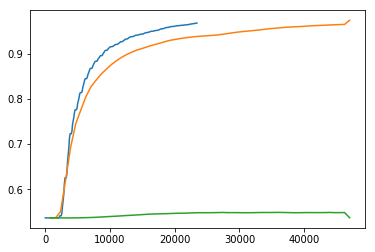

In [128]:
start = time.time()
#Parameters
M = 50
N = 50
rho = 1.8e-7
b = 5
T = 1
rounds = 2
iteration = 60
for r in range(rounds):
    #Generate graph
    W_0, graph = gen_graph(M, con_rate=50, b=b)
    neighbors = get_neighbor(graph) 
    #Training set distribution / test data
    #5421 0, 5851 1
    training_data = []
    set_trn_0, set_tst_0, set_trn_1, set_tst_1 = data_01()
    test_data = np.concatenate((set_tst_1, set_tst_0))
    test_label = np.concatenate( (np.ones(len(set_tst_1)), (-1) * np.ones(len(set_tst_0))))
    for node in range(M):
        training_data.append(set_trn_1[(node * N) : (node * N + N)] + set_trn_0[(node * N) : (node * N + N)])
    training_label = [1] * N + [-1] * N #1 labels 1, 0 labels -1
    #Initialization
    W_ini = [np.random.rand(784) for _ in range(M)]
#     #ByRDiE
#     W_byrdie = ByRDiE(W_ini, training_data, training_label, neighbors, T, rho, N, M, b, iteration)
#     #Save consensus / accuracy
#     with open('./result/BVB_byrdie_2%d.pickle'%r, 'wb') as handle:
#         pickle.dump(W_byrdie, handle)
    #BRIDGE
    W_bridge = BRIDGE(W_ini, training_data, training_label, neighbors, rho, N, M, b, iteration)
    #Save consensus / accuracy
    with open('./result/BVB_bridge_2%d.pickle'%r, 'wb') as handle:
        pickle.dump(W_bridge, handle)       
#     #DGD
    W_dgd = DGD(W_ini, training_data, training_label, neighbors, rho, N, M, b, iteration)
    #Save consensus / accuracy
    with open('./result/BVB_dgd_1%d.pickle'%r, 'wb') as handle:
        pickle.dump(W_dgd, handle)   
    print(time.time() - start)
    start = time.time()

bridge = []
acc_bridge = []
for r in range(rounds):
    with open('./result/BVB_bridge_2%d.pickle'%r, 'rb') as handle:
        bridge.append(pickle.load(handle))
for r in range(rounds):
    one_round = []
    for w in bridge[r]:
        acc = test(w, test_data, test_label) # 50
        one_round.append(acc) # 30
    acc_bridge.append(one_round) 
with open('./result/BVB_bridge_accuracy.pickle', 'wb') as handle:
    pickle.dump(acc_bridge, handle)
acc_bridge = np.mean(acc_bridge, axis = 0)
print(len(acc_bridge)) # 30
print(len(acc_bridge[0])) # 50

dgd = []
acc_dgd = []
for r in range(rounds):
    with open('./result/BVB_dgd_1%d.pickle'%r, 'rb') as handle:
        dgd.append(pickle.load(handle))
for r in range(rounds):
    one_round = []
    for w in dgd[r]:
        acc = test(w, test_data, test_label) # 50
        one_round.append(acc) # 30
    acc_dgd.append(one_round) 
with open('./result/BVB_dgd_accuracy.pickle', 'wb') as handle:
    pickle.dump(acc_dgd, handle)
acc_dgd = np.mean(acc_dgd, axis = 0)
print(len(acc_dgd)) # 30
print(len(acc_dgd[0])) # 50

from matplotlib import pyplot as plt
bridge_b4 = []
byrdie_b4 = []
dgd_b4 = []
axis_byrdie = []
for r in range(30):
    for n in range(780):
        if n % 100 == 1:
            axis_byrdie.append(r * 784 + n)
axis_dgd = [784 * n for n in range(1, 61)]
axis_bridge = [784 * n for n in range(1, 61)]
for t in range(len(acc_byrdie)):
    ave_acc = np.mean(acc_byrdie[t][4:])
    byrdie_b4.append(ave_acc)
for t in range(len(acc_bridge)):
    ave_acc = np.mean(acc_bridge[t][4:])
    bridge_b4.append(ave_acc)
for t in range(len(acc_dgd)):
    ave_acc = np.mean(acc_dgd[t][4:])
    dgd_b4.append(ave_acc)

plt.plot(axis_byrdie, byrdie_b4)
plt.plot(axis_bridge, bridge_b4)
plt.plot(axis_dgd, dgd_b4)
plt.show()